In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, classification_report, confusion_matrix)
%matplotlib inline

In [88]:
df = pd.read_csv('NVDA.csv')
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,Date,Adj Close,Close,High,Low,Open,Volume
0,28/11/2022,15.812541,15.827000,16.357000,15.725,16.025999,303741000
1,29/11/2022,15.624713,15.639000,15.932000,15.520,15.827000,298384000
2,30/11/2022,16.911863,16.923000,16.930000,15.597,15.697000,565298000
3,01/12/2022,17.123726,17.135000,17.264999,16.635,16.999001,470977000
4,02/12/2022,16.864895,16.875999,16.933001,16.445,16.659000,371389000


In [89]:
def handle_missing_data(data):
    """
    Check for missing data
    """
    print("Missing Data Summary:\n", df.isnull().sum())
    return data.fillna(df.mean(numeric_only=True), inplace=True)

data_cleaned = handle_missing_data(df)

Missing Data Summary:
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [90]:
# Create target variable (1 if price went up, 0 if down)
df['Target'] = (df['Adj Close'].shift(-1) > df['Adj Close']).astype(int)

# Create technical indicators
df['Returns'] = df['Adj Close'].pct_change()
df['Volume_Change'] = df['Volume'].pct_change()
df['High_Low_Range'] = df['High'] - df['Low']
df['Open_Close_Range'] = df['Close'] - df['Open']

# Create moving averages
df['MA5'] = df['Adj Close'].rolling(window=5).mean()
df['MA20'] = df['Adj Close'].rolling(window=20).mean()

# Create RSI
delta = df['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values
df = df.dropna()

# Select features for model
features = ['Returns', 'Volume_Change', 'High_Low_Range',
           'Open_Close_Range', 'MA5', 'MA20', 'RSI']

print("\nFeatures created:")
for feature in features:
    print(f"- {feature}")


Features created:
- Returns
- Volume_Change
- High_Low_Range
- Open_Close_Range
- MA5
- MA20
- RSI



Basic Statistics:


,Returns,Volume_Change,High_Low_Range,Open_Close_Range,MA5,MA20,RSI,Target
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.005041,0.037786,2.601826,-0.005339,68.141253,66.166864,59.572489,0.566116
std,0.032293,0.301342,2.193877,2.066884,39.531393,38.650718,16.487282,0.496122
min,-0.100046,-0.672406,0.378000,-9.020004,14.328366,15.460720,8.187870,0.000000
25%,-0.014464,-0.157882,1.012001,-0.621502,41.237969,39.008301,47.224812,0.000000
50%,0.004303,-0.015863,1.764502,0.095000,48.851154,47.781315,61.427275,1.000000
75%,0.022595,0.180440,3.547504,0.828501,106.303406,101.884240,71.353040,1.000000
max,0.243696,1.228817,13.350006,8.389999,147.266000,142.878999,96.994857,1.000000


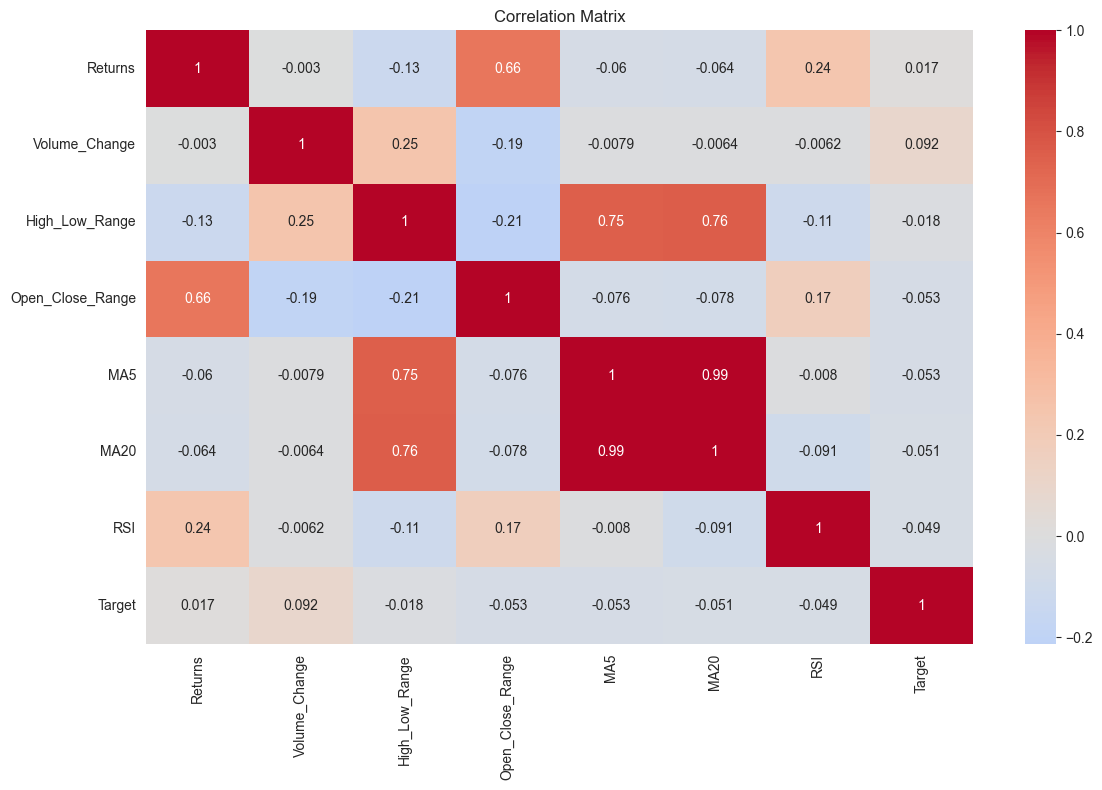

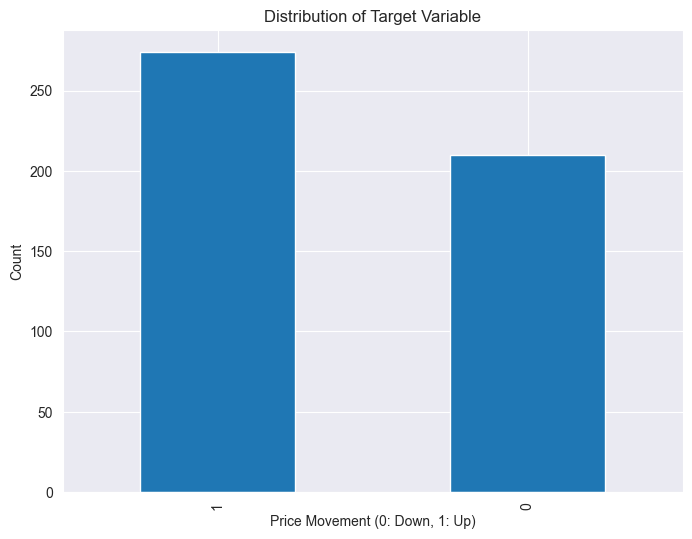

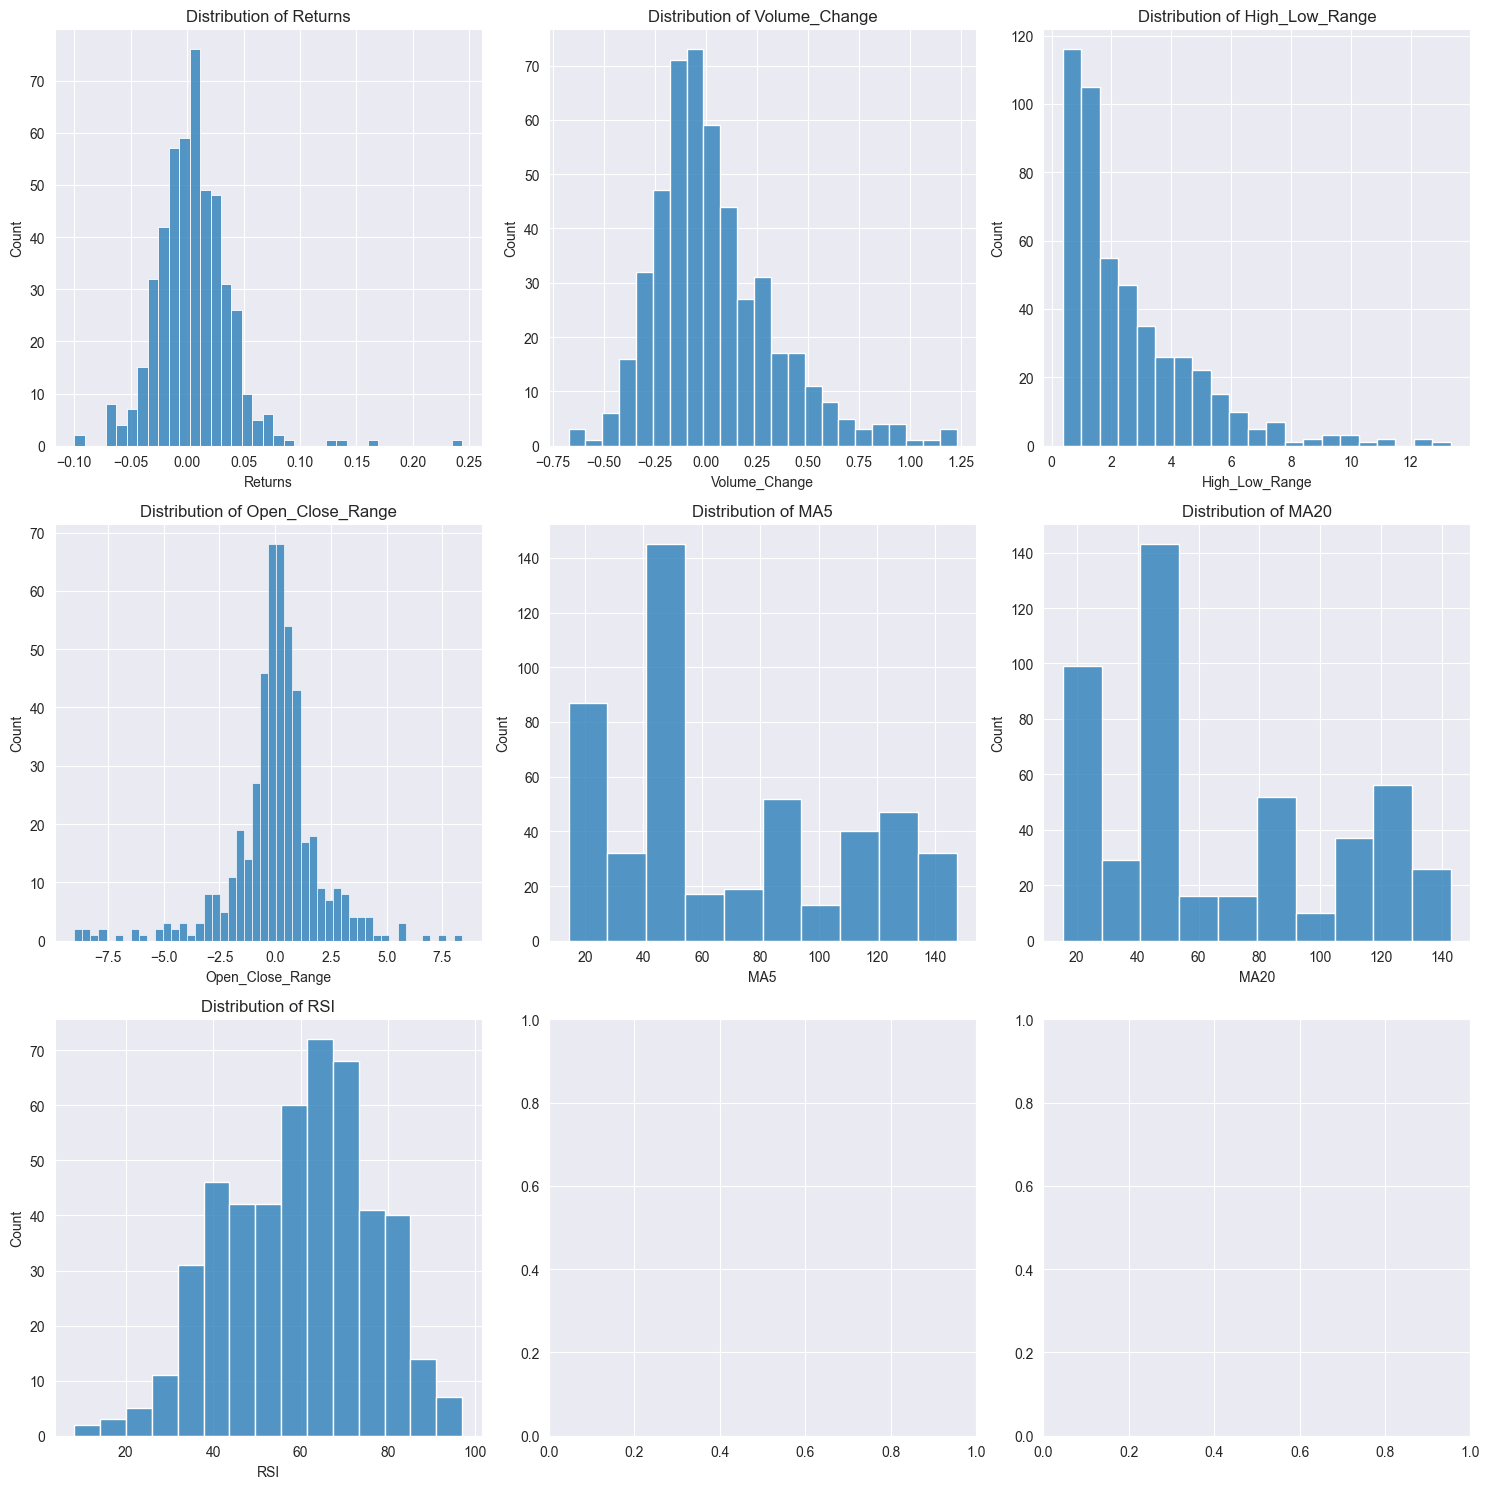

In [91]:
# Basic statistics
print("\nBasic Statistics:")
display(df[features + ['Target']].describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(8, 6))
df['Target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Price Movement (0: Down, 1: Up)')
plt.ylabel('Count')
plt.show()

# Feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, col in enumerate(features):
    if idx < len(axes):
        sns.histplot(data=df, x=col, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [92]:
# Cell 5: Data Split
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (387, 7)
Testing set shape: (97, 7)


In [93]:
# Cell 6: Train Models
# Gini Model
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

# Entropy Model
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [94]:
path = dt_gini.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00221484 0.00226098 0.00226098 0.00231667 0.00232558
 0.00236865 0.00238521 0.00241171 0.00246093 0.00310078 0.00316537
 0.00332226 0.00344531 0.00344531 0.00344531 0.00351708 0.00364004
 0.00375156 0.00387597 0.00401556 0.00401952 0.00413437 0.00413437
 0.00413437 0.0041899  0.00422986 0.00430663 0.00430663 0.00430663
 0.00430663 0.00434639 0.00458112 0.00466552 0.00482343 0.00506857
 0.00543996 0.00561807 0.00564478 0.00639535 0.00747173 0.00872093
 0.00918482 0.00956735 0.01020885 0.01145817 0.01358131]


In [95]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

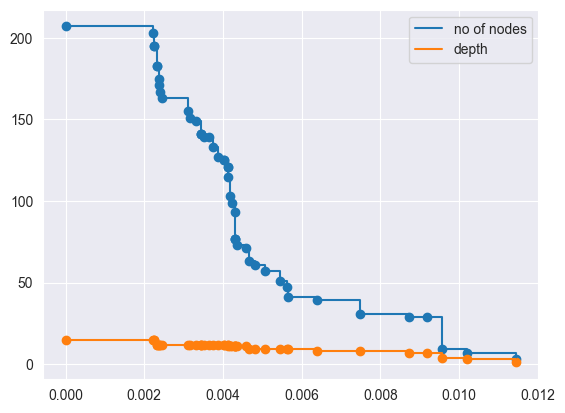

In [96]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

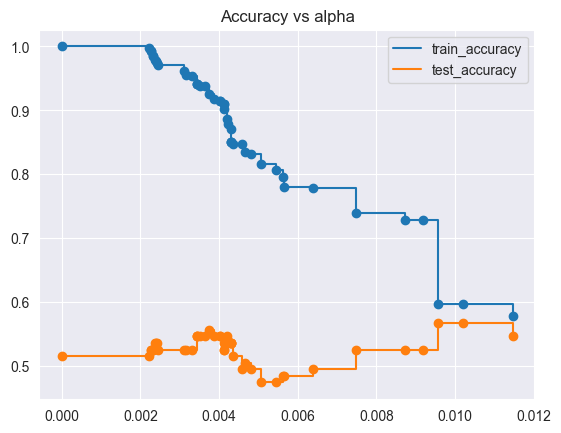

In [97]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [98]:
# Cell 7: Model Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_pred, y_pred_proba

# Evaluate both models
y_pred_gini, y_pred_proba_gini = evaluate_model(dt_gini, X_test, y_test, "Gini Model")
y_pred_entropy, y_pred_proba_entropy = evaluate_model(dt_entropy, X_test, y_test, "Entropy Model")


Gini Model Results:
Accuracy: 0.5464
Precision: 0.6818
Recall: 0.5000
F1 Score: 0.5769

Entropy Model Results:
Accuracy: 0.5773
Precision: 0.7021
Recall: 0.5500
F1 Score: 0.6168


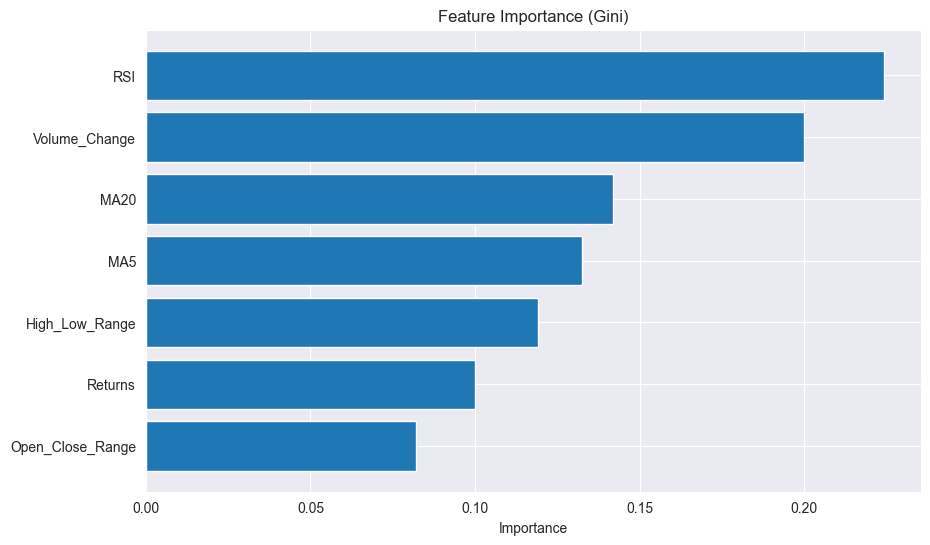

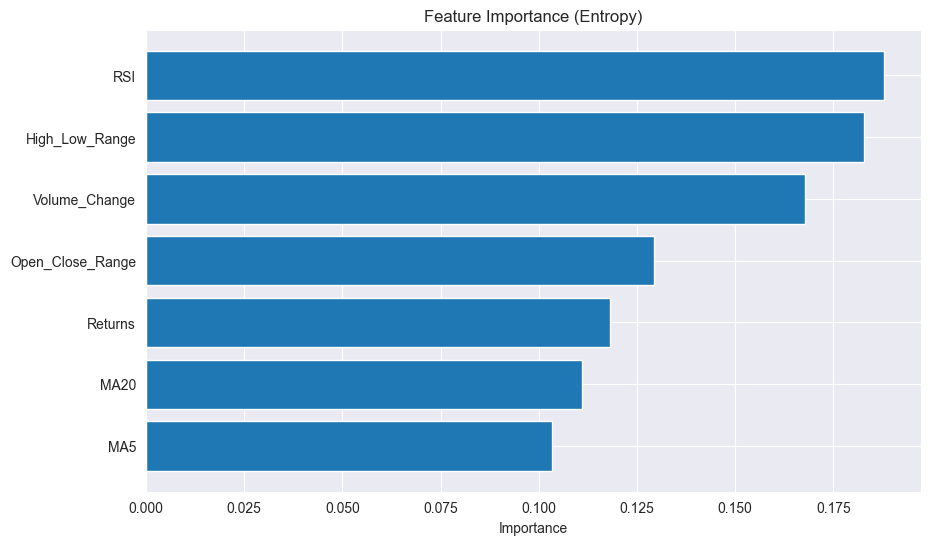

In [99]:
# Cell 8: Feature Importance
def plot_feature_importance(model, features, model_name):
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importances['feature'], importances['importance'])
    plt.title(f'Feature Importance ({model_name})')
    plt.xlabel('Importance')
    plt.show()

plot_feature_importance(dt_gini, features, "Gini")
plot_feature_importance(dt_entropy, features, "Entropy")

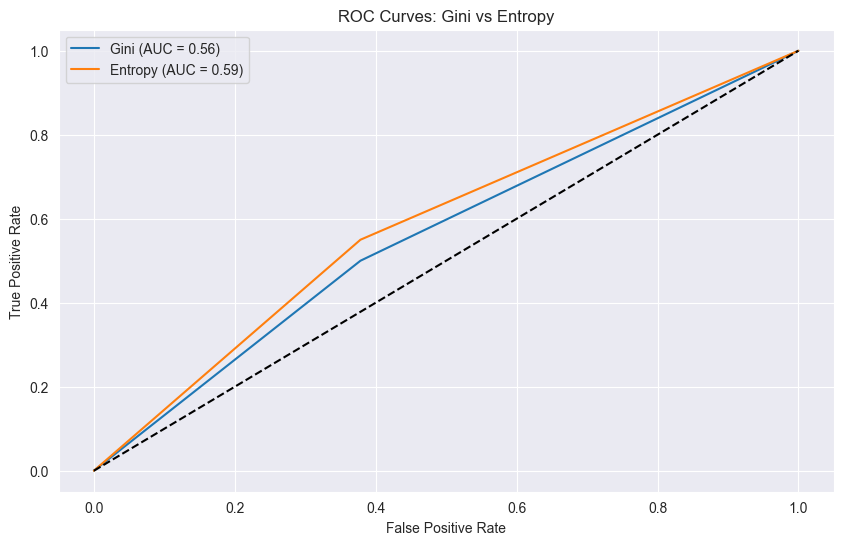

In [100]:
# Cell 9: ROC Curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Gini vs Entropy')
    plt.legend()
    plt.show()

plot_roc_curves({'Gini': dt_gini, 'Entropy': dt_entropy}, X_test, y_test)

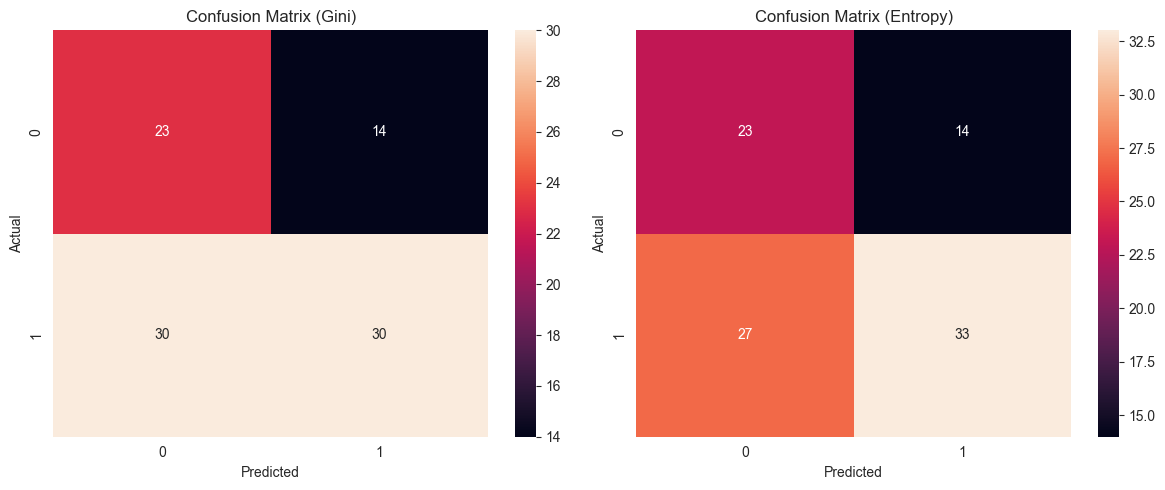

In [101]:
# Cell 10: Confusion Matrices
def plot_confusion_matrices(y_test, y_pred_gini, y_pred_entropy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(confusion_matrix(y_test, y_pred_gini), annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix (Gini)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    sns.heatmap(confusion_matrix(y_test, y_pred_entropy), annot=True, fmt='d', ax=ax2)
    ax2.set_title('Confusion Matrix (Entropy)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test, y_pred_gini, y_pred_entropy)

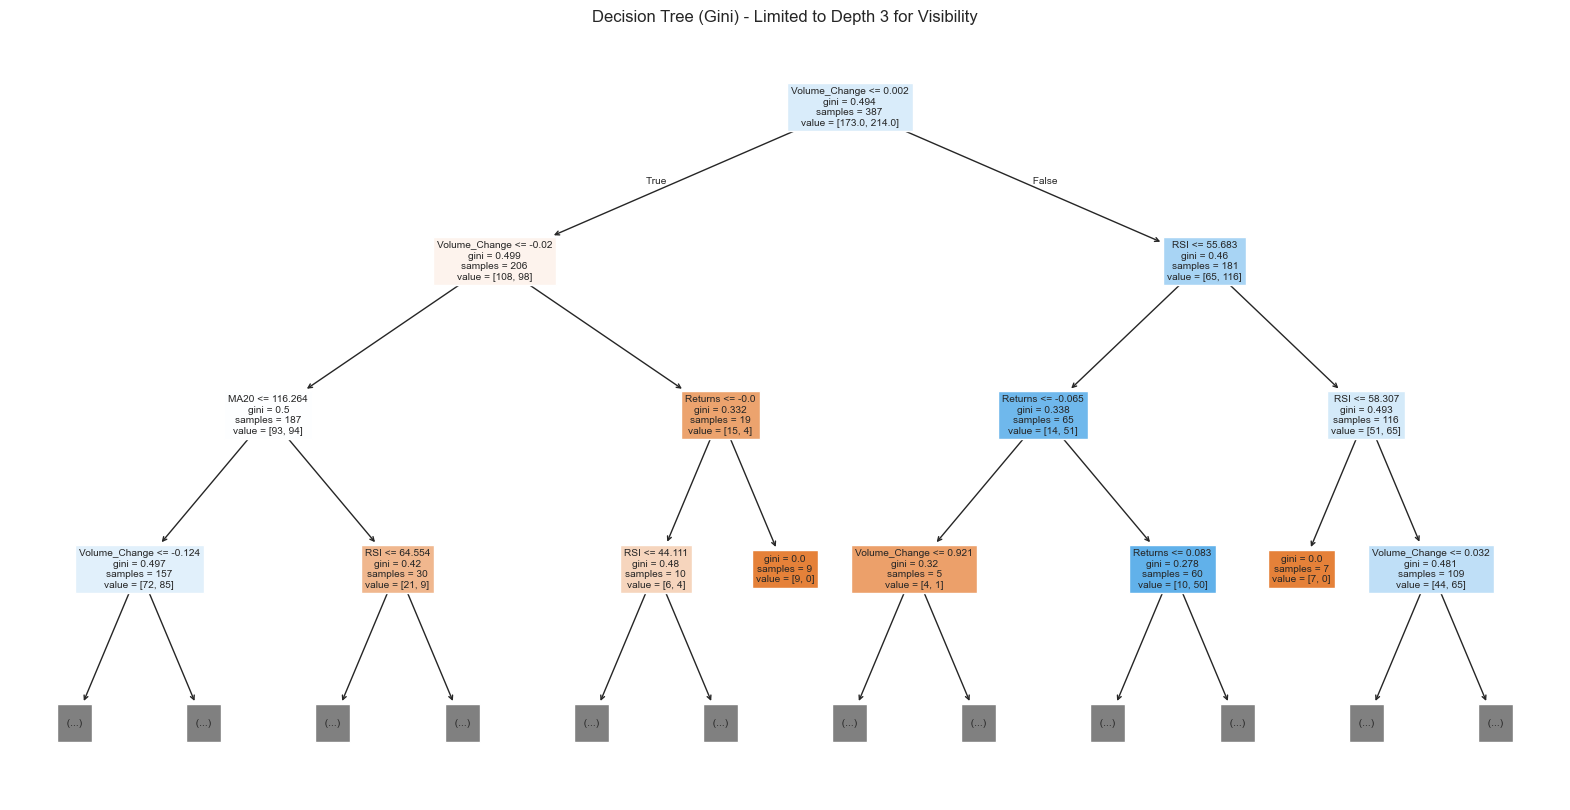

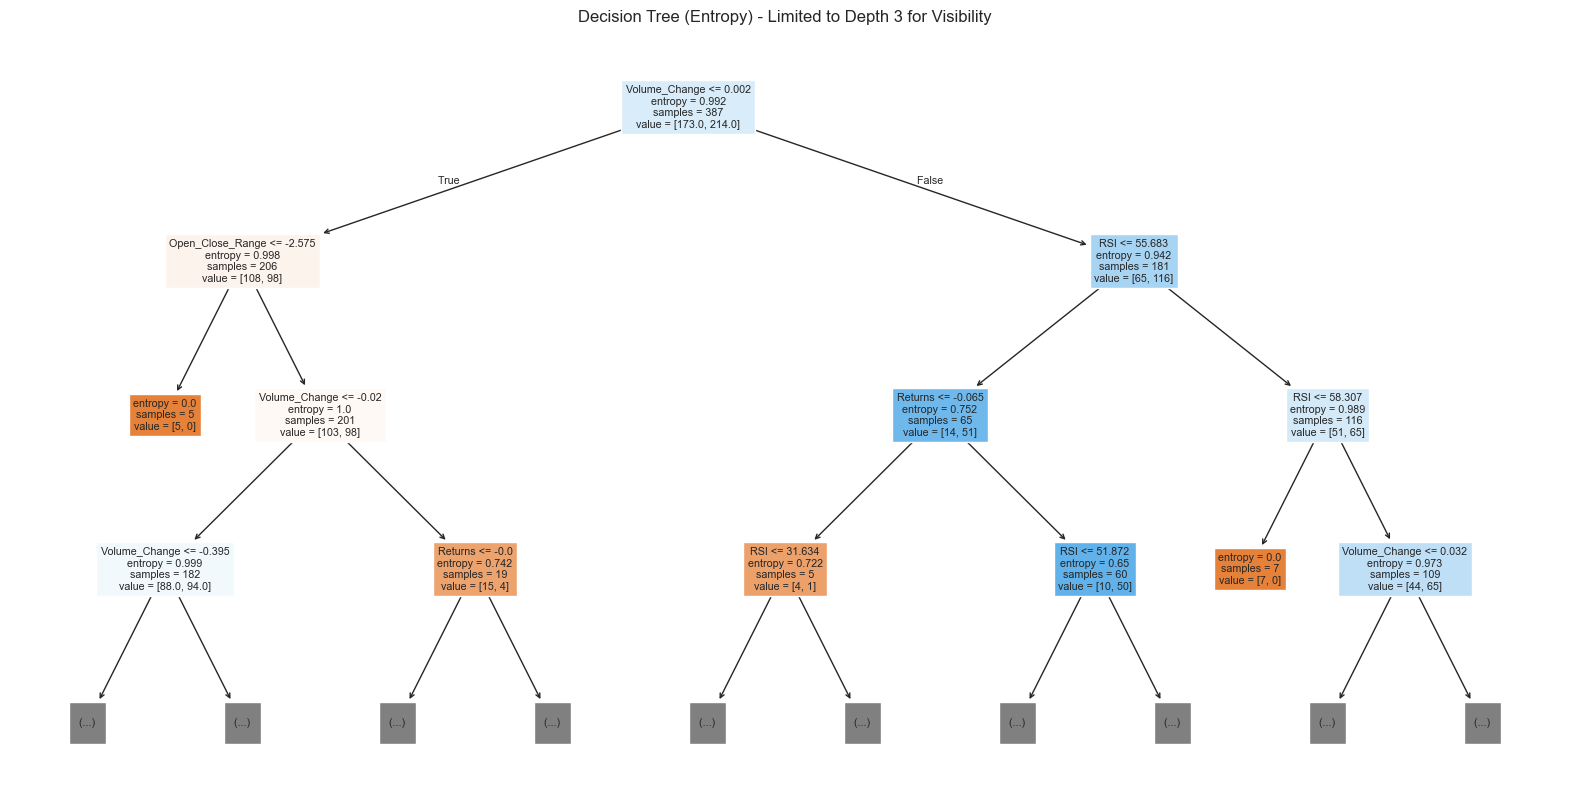

In [102]:
# Cell 11: Visualize Decision Trees
plt.figure(figsize=(20, 10))
plot_tree(dt_gini, feature_names=features, filled=True, max_depth=3)
plt.title('Decision Tree (Gini) - Limited to Depth 3 for Visibility')
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(dt_entropy, feature_names=features, filled=True, max_depth=3)
plt.title('Decision Tree (Entropy) - Limited to Depth 3 for Visibility')
plt.show()

In [103]:
print("Model Comparison Summary:")
print("-" * 50)

# Compare feature importances
gini_importances = pd.DataFrame({
    'feature': features,
    'gini_importance': dt_gini.feature_importances_
})

entropy_importances = pd.DataFrame({
    'feature': features,
    'entropy_importance': dt_entropy.feature_importances_
})

comparison = gini_importances.merge(entropy_importances, on='feature')
comparison = comparison.sort_values('gini_importance', ascending=False)

print("\nFeature Importance Comparison:")
display(comparison)

print("\nKey Findings:")
print("1. Model Performance:")
print("   - Compare accuracy, precision, recall, and F1 scores above")
print("2. Feature Importance:")
print(f"   - Most important feature (Gini): {comparison.iloc[0]['feature']}")
print(f"   - Most important feature (Entropy): {comparison.iloc[0]['feature']}")
print("3. ROC Analysis:")
print("   - Compare AUC scores from ROC curves above")
print("4. Model Complexity:")
print(f"   - Gini tree depth: {dt_gini.get_depth()}")
print(f"   - Entropy tree depth: {dt_entropy.get_depth()}")

Model Comparison Summary:
--------------------------------------------------

Feature Importance Comparison:


,feature,gini_importance,entropy_importance
6,RSI,0.224202,0.187861
1,Volume_Change,0.200046,0.167657
5,MA20,0.141853,0.111034
4,MA5,0.132500,0.103346
2,High_Low_Range,0.119242,0.182729
0,Returns,0.100083,0.118095
3,Open_Close_Range,0.082075,0.129278



Key Findings:
1. Model Performance:
   - Compare accuracy, precision, recall, and F1 scores above
2. Feature Importance:
   - Most important feature (Gini): RSI
   - Most important feature (Entropy): RSI
3. ROC Analysis:
   - Compare AUC scores from ROC curves above
4. Model Complexity:
   - Gini tree depth: 15
   - Entropy tree depth: 17



Original Gini Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        37
           1       0.68      0.50      0.58        60

    accuracy                           0.55        97
   macro avg       0.56      0.56      0.54        97
weighted avg       0.59      0.55      0.55        97



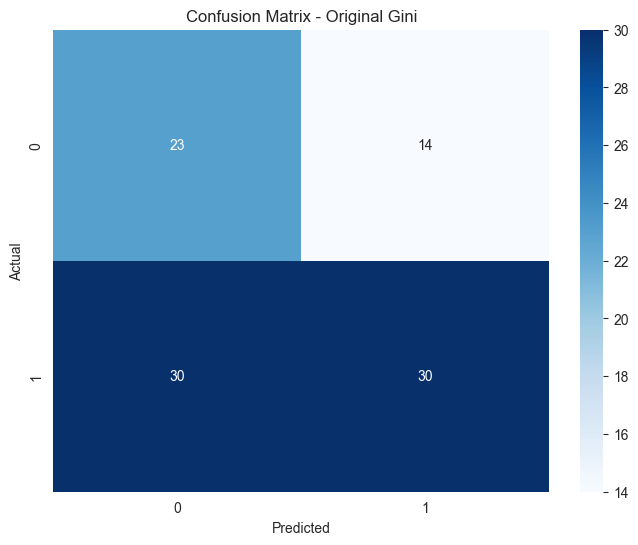


Original Entropy Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.62      0.53        37
           1       0.70      0.55      0.62        60

    accuracy                           0.58        97
   macro avg       0.58      0.59      0.57        97
weighted avg       0.61      0.58      0.58        97



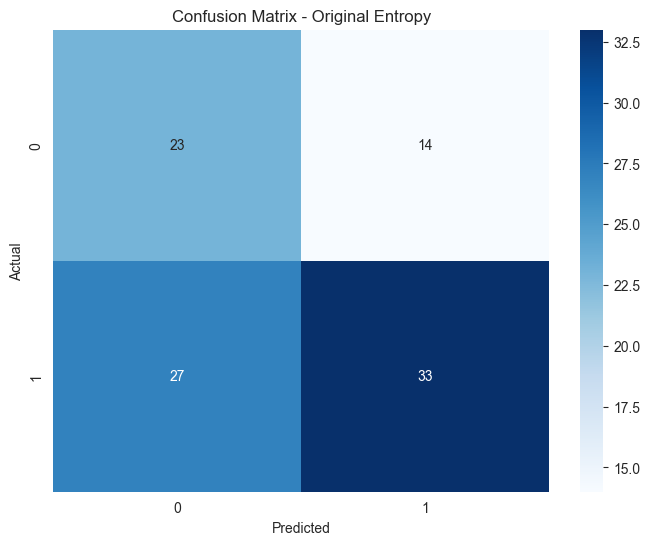


Pruned Gini (Config 1) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.49      0.43        37
           1       0.63      0.53      0.58        60

    accuracy                           0.52        97
   macro avg       0.51      0.51      0.51        97
weighted avg       0.54      0.52      0.52        97



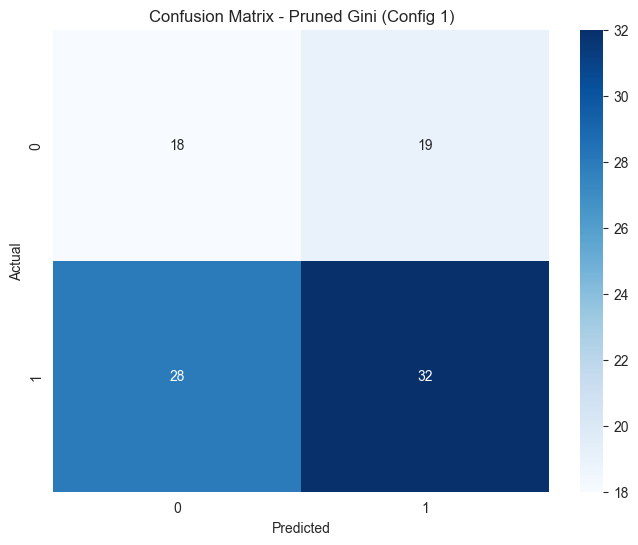


Pruned Entropy (Config 1) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        37
           1       0.65      0.60      0.63        60

    accuracy                           0.56        97
   macro avg       0.54      0.54      0.54        97
weighted avg       0.57      0.56      0.56        97



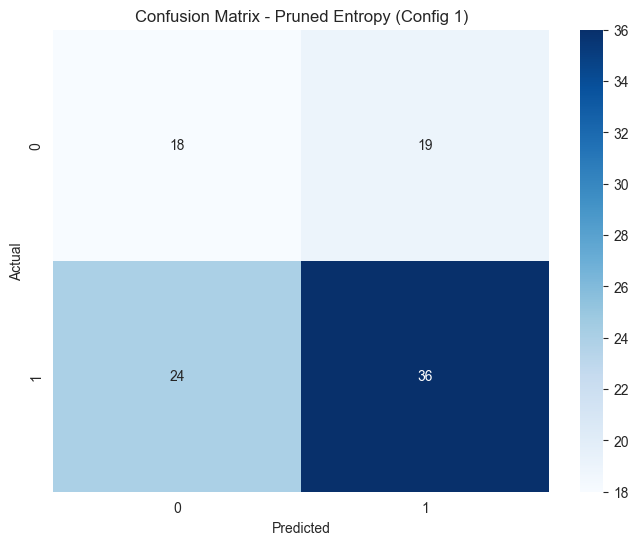


Pruned Gini (Config 2) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.65      0.50        37
           1       0.66      0.42      0.51        60

    accuracy                           0.51        97
   macro avg       0.53      0.53      0.51        97
weighted avg       0.56      0.51      0.51        97



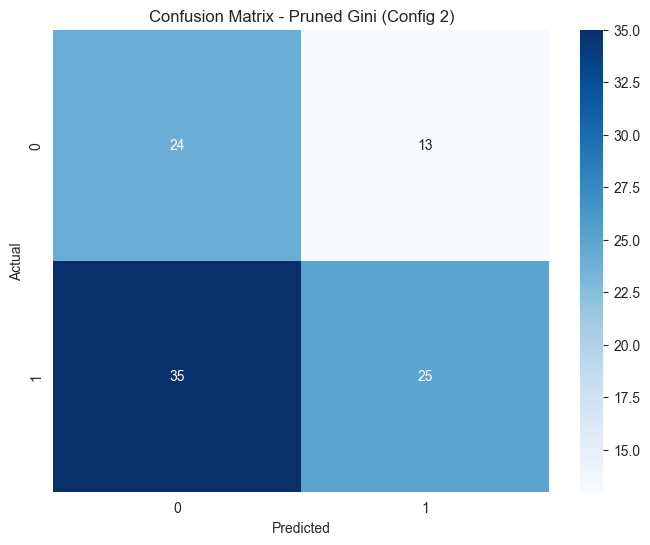


Pruned Entropy (Config 2) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.49      0.42        37
           1       0.61      0.50      0.55        60

    accuracy                           0.49        97
   macro avg       0.49      0.49      0.49        97
weighted avg       0.52      0.49      0.50        97



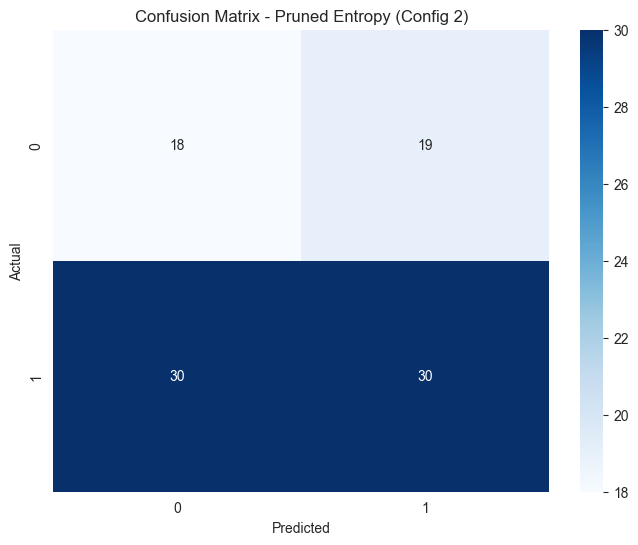


Pruned Gini (Config 3) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.27      0.33        37
           1       0.63      0.77      0.69        60

    accuracy                           0.58        97
   macro avg       0.52      0.52      0.51        97
weighted avg       0.55      0.58      0.55        97



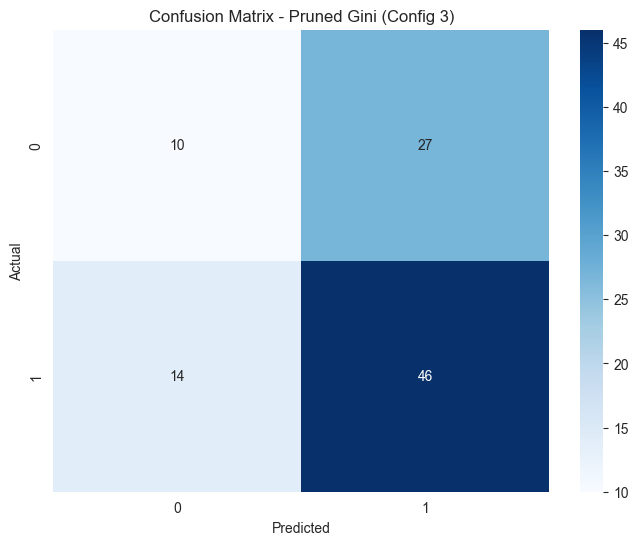


Pruned Entropy (Config 3) Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.11      0.17        37
           1       0.62      0.90      0.73        60

    accuracy                           0.60        97
   macro avg       0.51      0.50      0.45        97
weighted avg       0.54      0.60      0.52        97



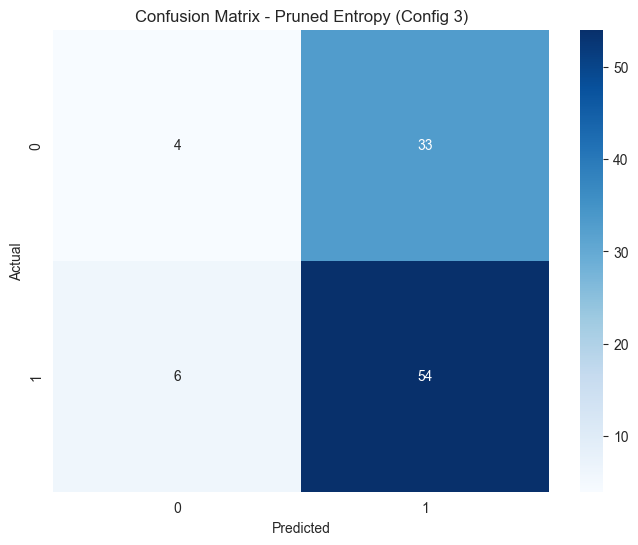


Model Performance Comparison:
                           accuracy  precision    recall  f1_score  \
Original Gini              0.546392   0.681818  0.500000  0.576923   
Original Entropy           0.577320   0.702128  0.550000  0.616822   
Pruned Gini (Config 1)     0.515464   0.627451  0.533333  0.576577   
Pruned Entropy (Config 1)  0.556701   0.654545  0.600000  0.626087   
Pruned Gini (Config 2)     0.505155   0.657895  0.416667  0.510204   
Pruned Entropy (Config 2)  0.494845   0.612245  0.500000  0.550459   
Pruned Gini (Config 3)     0.577320   0.630137  0.766667  0.691729   
Pruned Entropy (Config 3)  0.597938   0.620690  0.900000  0.734694   

                           cv_mean_score  cv_std_score  
Original Gini                   0.514119      0.055373  
Original Entropy                0.521778      0.044477  
Pruned Gini (Config 1)          0.506394      0.020377  
Pruned Entropy (Config 1)       0.496071      0.022693  
Pruned Gini (Config 2)          0.511622      0.03667

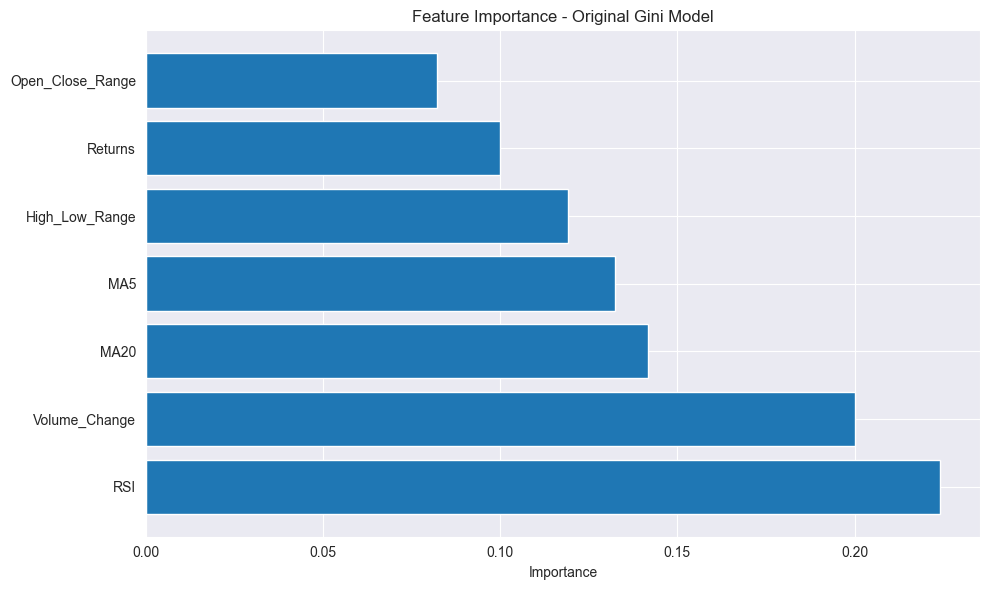

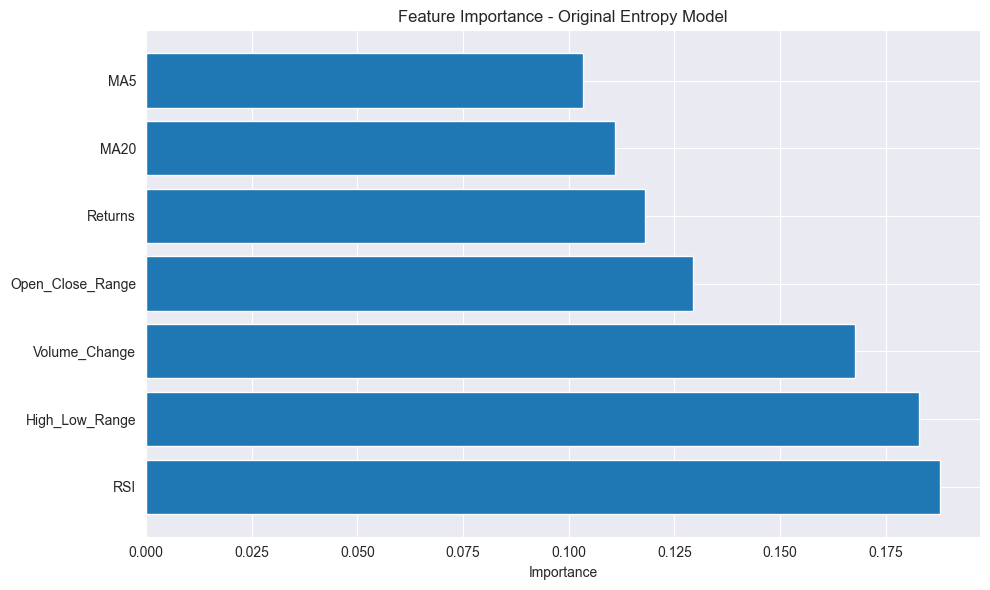

In [104]:
def comprehensive_model_comparison(X_train, X_test, y_train, y_test, features):
    """
    Comprehensive comparison of original and pruned decision trees
    Pre-Pruning Techniques
    """
    # Original models
    dt_gini_original = DecisionTreeClassifier(criterion='gini', random_state=42)
    dt_entropy_original = DecisionTreeClassifier(criterion='entropy', random_state=42)

    # Train original models
    dt_gini_original.fit(X_train, y_train)
    dt_entropy_original.fit(X_train, y_train)

    # Pruning options
    pruning_configs = [
        # Conservative pruning
        {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2},
        # Moderate pruning
        {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4},
        # Aggressive pruning
        {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 5}
    ]

    # Function to evaluate model
    def evaluate_model(model, X_test, y_test, model_type):
        y_pred = model.predict(X_test)

        print(f"\n{model_type} Model Evaluation:")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_type}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'cv_mean_score': cv_scores.mean(),
            'cv_std_score': cv_scores.std()
        }

    # Comparison results storage
    results = {
        'Original Gini': evaluate_model(dt_gini_original, X_test, y_test, "Original Gini"),
        'Original Entropy': evaluate_model(dt_entropy_original, X_test, y_test, "Original Entropy")
    }

    # Pruning exploration
    for i, config in enumerate(pruning_configs, 1):
        # Gini pruned
        dt_gini_pruned = DecisionTreeClassifier(
            criterion='gini',
            random_state=42,
            **config
        )
        dt_gini_pruned.fit(X_train, y_train)

        # Entropy pruned
        dt_entropy_pruned = DecisionTreeClassifier(
            criterion='entropy',
            random_state=42,
            **config
        )
        dt_entropy_pruned.fit(X_train, y_train)

        # Evaluate pruned models
        results[f'Pruned Gini (Config {i})'] = evaluate_model(
            dt_gini_pruned, X_test, y_test, f"Pruned Gini (Config {i})"
        )
        results[f'Pruned Entropy (Config {i})'] = evaluate_model(
            dt_entropy_pruned, X_test, y_test, f"Pruned Entropy (Config {i})"
        )

    # Create comparison DataFrame
    comparison_df = pd.DataFrame.from_dict(results, orient='index')
    print("\nModel Performance Comparison:")
    print(comparison_df)

    # Visualize feature importances
    def plot_feature_importance(model, features, title):
        importances = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(importances['feature'], importances['importance'])
        plt.title(title)
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

    # Feature importance for original models
    plot_feature_importance(dt_gini_original, features, 'Feature Importance - Original Gini Model')
    plot_feature_importance(dt_entropy_original, features, 'Feature Importance - Original Entropy Model')

    return results, comparison_df

# Run the comparison (assuming previous data preparation)
results, comparison_df = comprehensive_model_comparison(X_train, X_test, y_train, y_test, features)

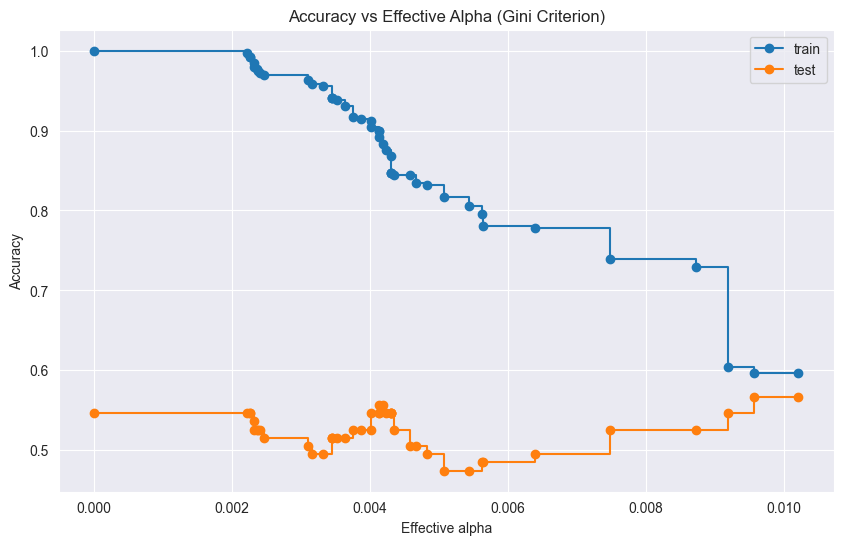


Optimal Pruned Tree (Gini Criterion):
Optimal Alpha: 0.0096

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.68      0.54        37
           1       0.71      0.50      0.59        60

    accuracy                           0.57        97
   macro avg       0.58      0.59      0.57        97
weighted avg       0.62      0.57      0.57        97



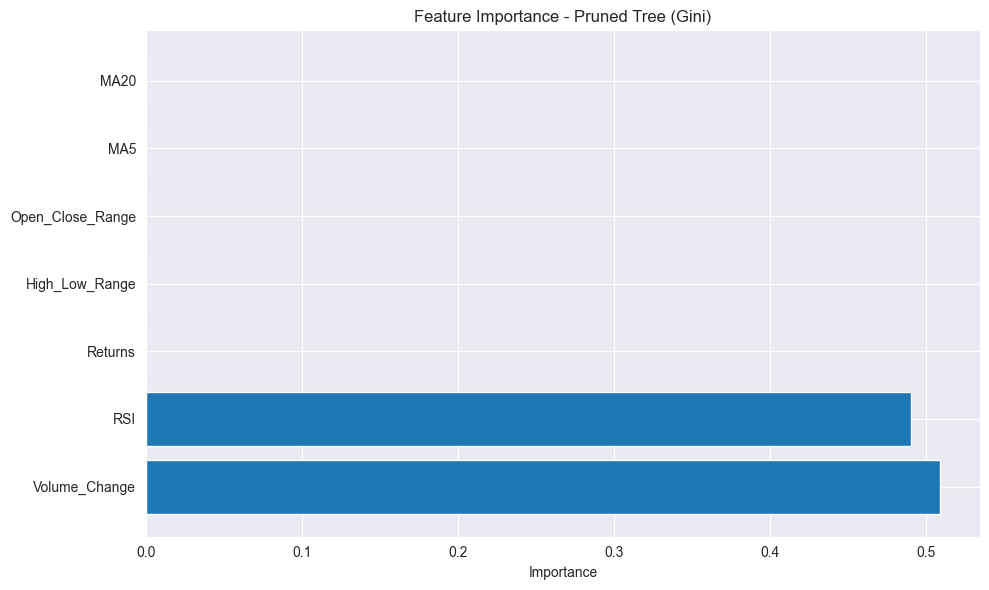

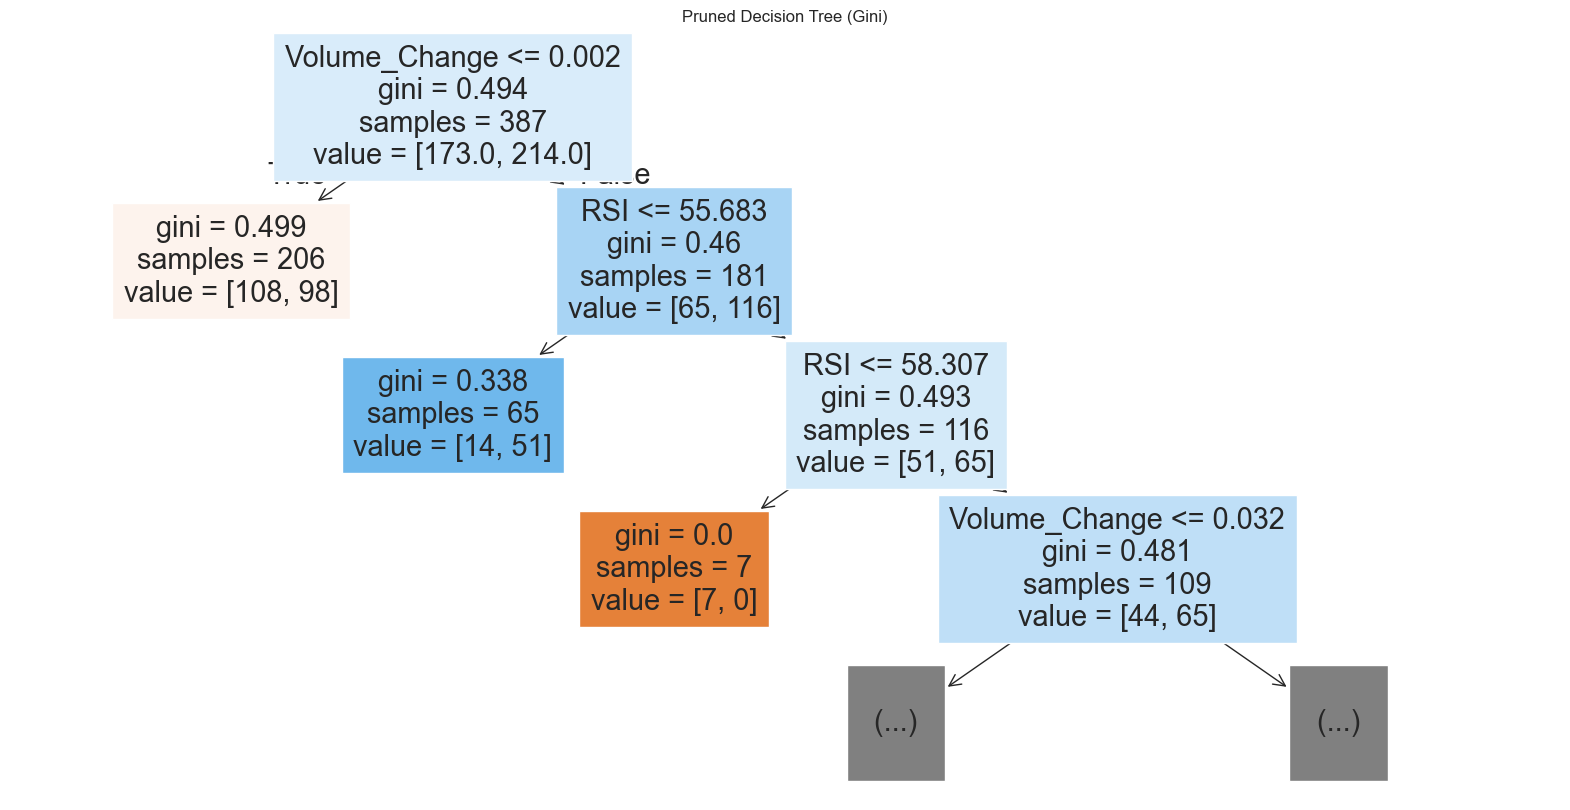

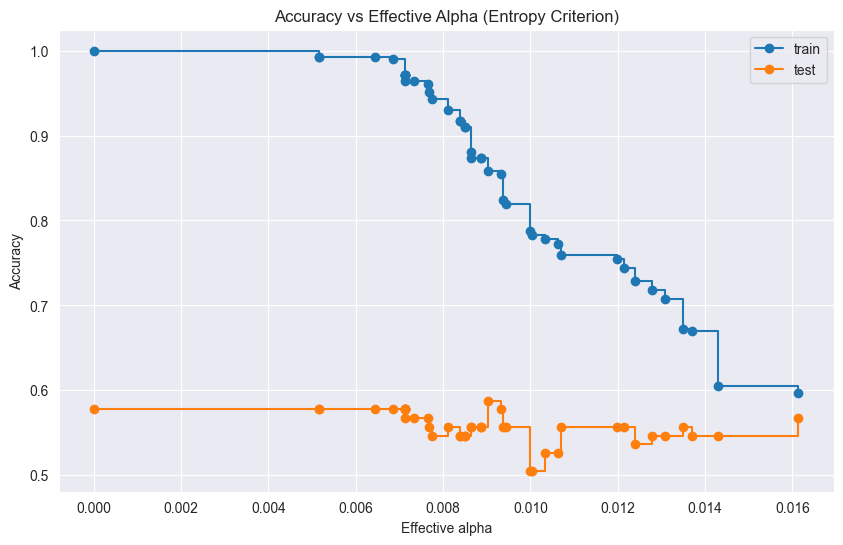


Optimal Pruned Tree (Entropy Criterion):
Optimal Alpha: 0.0090

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.57      0.51        37
           1       0.69      0.60      0.64        60

    accuracy                           0.59        97
   macro avg       0.58      0.58      0.58        97
weighted avg       0.61      0.59      0.59        97



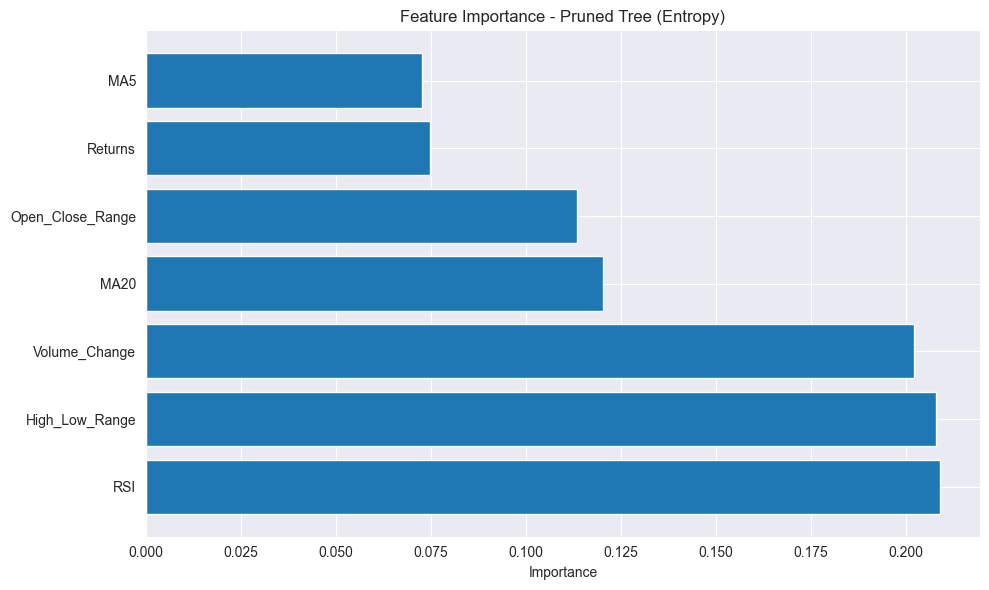

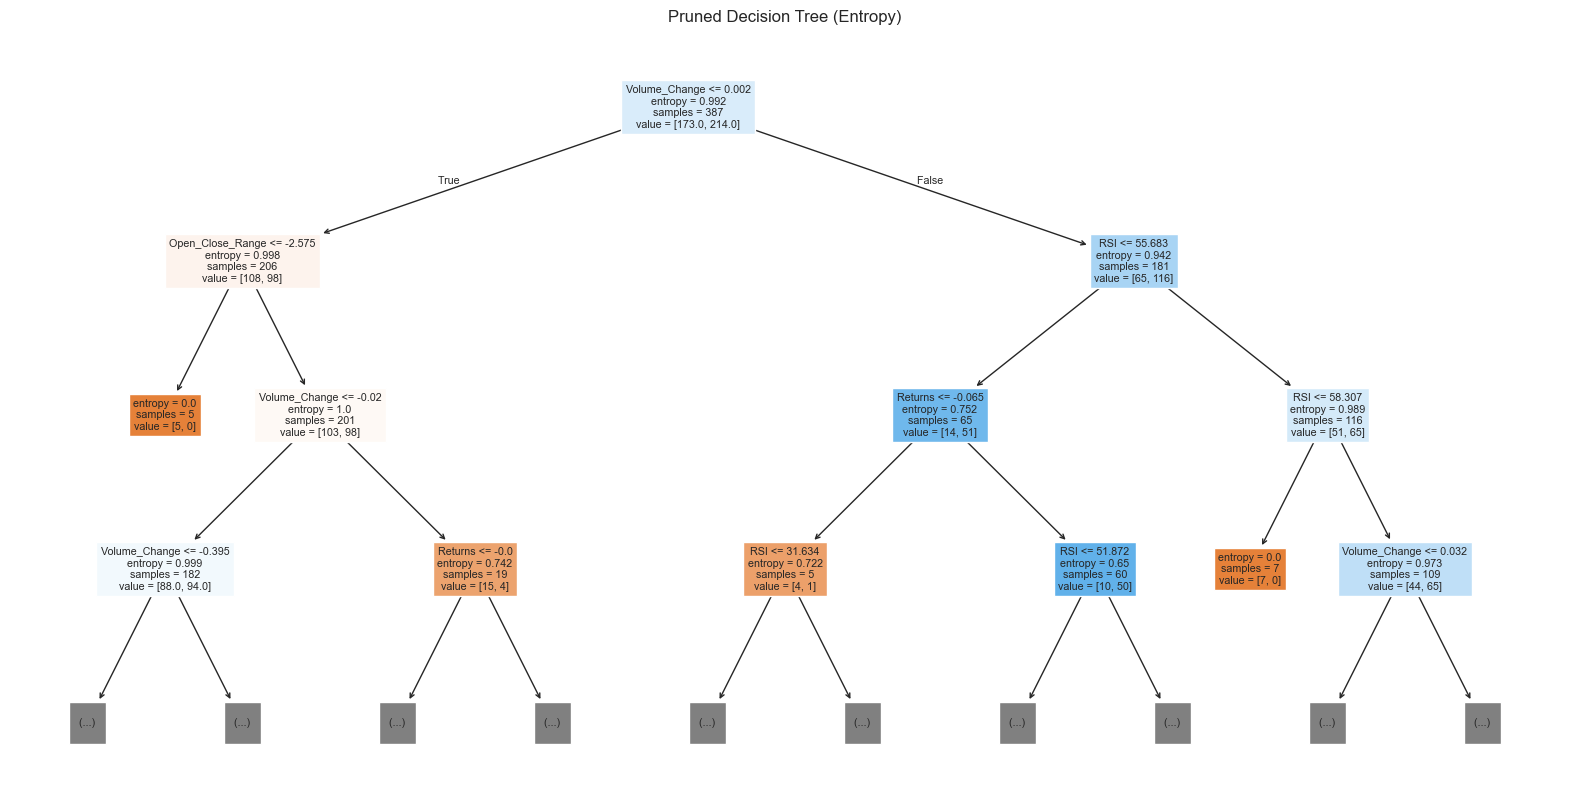


Comparison of Original and Pruned Trees:
Gini Criterion:
Original Tree Depth: 15
Pruned Tree Depth: 4

Entropy Criterion:
Original Tree Depth: 17
Pruned Tree Depth: 14


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

def post_pruning_analysis(X_train, X_test, y_train, y_test, features):
    """
    Perform post-pruning analysis using cost complexity pruning
    """
    # Train a full decision tree
    full_tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
    full_tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

    full_tree_gini.fit(X_train, y_train)
    full_tree_entropy.fit(X_train, y_train)

    def cost_complexity_pruning(tree, X_train, y_train, X_test, y_test, criterion='gini'):
        """
        Perform cost complexity pruning
        """
        # Compute path for different alpha values
        path = tree.cost_complexity_pruning_path(X_train, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities

        # Train trees with different alpha values
        clfs = []
        for ccp_alpha in ccp_alphas:
            clf = DecisionTreeClassifier(
                random_state=42,
                criterion=criterion,
                ccp_alpha=ccp_alpha
            )
            clf.fit(X_train, y_train)
            clfs.append(clf)

        # Remove the last element as it is the trivial tree with only one node
        clfs = clfs[:-1]
        ccp_alphas = ccp_alphas[:-1]

        # Compute accuracy scores
        train_scores = [clf.score(X_train, y_train) for clf in clfs]
        test_scores = [clf.score(X_test, y_test) for clf in clfs]

        # Visualization of accuracy vs alpha
        plt.figure(figsize=(10, 6))
        plt.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="train",
                 drawstyle="steps-post")
        plt.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="test",
                 drawstyle="steps-post")
        plt.xlabel("Effective alpha")
        plt.ylabel("Accuracy")
        plt.title(f'Accuracy vs Effective Alpha ({criterion.capitalize()} Criterion)')
        plt.legend()
        plt.show()

        # Find the alpha that maximizes test accuracy
        optimal_alpha_idx = np.argmax(test_scores)
        optimal_alpha = ccp_alphas[optimal_alpha_idx]
        optimal_tree = clfs[optimal_alpha_idx]

        # Detailed evaluation of the optimal pruned tree
        y_pred = optimal_tree.predict(X_test)

        print(f"\nOptimal Pruned Tree ({criterion.capitalize()} Criterion):")
        print(f"Optimal Alpha: {optimal_alpha:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Feature importance of pruned tree
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': optimal_tree.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['feature'], feature_importance['importance'])
        plt.title(f'Feature Importance - Pruned Tree ({criterion.capitalize()})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        # Visualize pruned tree
        plt.figure(figsize=(20, 10))
        plot_tree(optimal_tree, feature_names=features, filled=True, max_depth=3)
        plt.title(f'Pruned Decision Tree ({criterion.capitalize()})')
        plt.show()

        return {
            'optimal_tree': optimal_tree,
            'optimal_alpha': optimal_alpha,
            'feature_importance': feature_importance
        }

    # Perform post-pruning for both Gini and Entropy criteria
    gini_pruning_results = cost_complexity_pruning(
        full_tree_gini, X_train, y_train, X_test, y_test, 'gini'
    )
    entropy_pruning_results = cost_complexity_pruning(
        full_tree_entropy, X_train, y_train, X_test, y_test, 'entropy'
    )

    return gini_pruning_results, entropy_pruning_results

# Run post-pruning analysis
gini_results, entropy_results = post_pruning_analysis(X_train, X_test, y_train, y_test, features)

# Compare original and pruned trees
print("\nComparison of Original and Pruned Trees:")
print("Gini Criterion:")
print(f"Original Tree Depth: {dt_gini.get_depth()}")
print(f"Pruned Tree Depth: {gini_results['optimal_tree'].get_depth()}")

print("\nEntropy Criterion:")
print(f"Original Tree Depth: {dt_entropy.get_depth()}")
print(f"Pruned Tree Depth: {entropy_results['optimal_tree'].get_depth()}")